## Example code accompanying Cusworth et al. (2021)
### "A Bayesian framework for deriving sector-based methane emissions from top-down fluxes"

This script can be used to partition Permian Basin fluxes derived from a TROPOMI inversion (Zhang et al., 2020) to unique emission sectors, based on a combination of prior inventories from Scarpelli et al., Maasakkers et al., and Ma et al. The mechanics of the code are based on Equations 1 and 2 from the manuscript.

The code is flexible such that if one wants to change flux and emission inputs, this can be run for a different region.

Contact: Daniel Cusworth (dcusworth@arizona.edu)
Date: July 12, 2021

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from netCDF4 import Dataset
import pandas as pd
import os, sys
import datetime
from calendar import monthrange
from scipy import interpolate
import geopandas as gpd
import fiona
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
from shapely.geometry import Polygon
import pickle
from scipy import sparse
import geopy.distance
from scipy.sparse import linalg
import cartopy.crs as ccrs


In [2]:
#~~~~~~~~ USER INPUTS ~~~~~~~~~~#

#Output file name
out_name = 'partition_output'

#Spatial domain to use - here takes the form of a shapefile
#that is used to clip the fluxes and state vector
us = gpd.read_file('./permian_basin.kml', driver='KML')

#If you've already run this routine before, there are intermediate
#files that are saved and can be reloaded to save time (e.g., matrix M)
already_ran = False


In [3]:
#~~~~~~~~ Open Inverse fluxes and the flux prior used in that inversion


#Here I am using Zhang et al. (2020) posterior fluxes from a 2018-2019 TROPOMI inversion
#DOI: 10.1126/sciadv.aaz5120
#Contact authors for access to the data:
#Email: zhangyuzhong@westlake.edu.cn (Y.Z.); rgautam@edf.org (R.G.)


#### Inverse scaling factors
fl1 = "./Zhang/Permian_Inversion.nc"
fl2 = "./Zhang/Methane_flux_Permian_EIBU.nc"
fl3 = "./Zhang/Permian_clust.nc"

nc = Dataset(fl1)
xhat_flux = nc["xhat"][:] #posterior scaling factors
shat = nc["Shat"][:] #Scaling factor posterior covariance matrix
SaCAP = nc["sa"][:] #prior covariance matrix - in scaling factor space
xa1 = nc["prior"][:] #prior in units kg m-2 s-1
hem_grid = xa1.copy()
AK = nc["AK"][:]
cllon = nc["lon"][:]
cllat = nc["lat"][:]
nc.close()

nc = Dataset(fl3)
cluster_lon = nc["lon"][:]
cluster_lat = nc["lat"][:]
clust = nc["Clusters"][:]
nc.close()

#List of cluster lat/lons
clgrid = pd.DataFrame(zip(cllon, cllat), columns=['lon', 'lat'])
clgrid['ind'] = np.arange(clgrid.shape[0])

#Get cluster indicies that will be used later for posterior updates
max_func = lambda x: np.where(x==np.max(x))[0][0]
mclust = np.apply_along_axis(max_func, 0, clust)

#Clip inverse flux to domain
cesp = gpd.GeoDataFrame(clgrid, geometry=gpd.points_from_xy(clgrid.lon, clgrid.lat))
cesp = cesp.set_crs("EPSG:4326")
csub = gpd.clip(cesp, us)
csel = csub.ind
clgrid_sel = clgrid.iloc[csel]


In [5]:
#~~~~~~~~~~~ Open our emissions prior - state vector we wish to update

##### Scarpelli et al. for oil/gas/coal
#Can access article data using following links
#DOI (article): https://doi.org/10.5194/essd-12-563-2020
#DOI (data): https://doi.org/10.7910/DVN/HH4EUM,

#Open files
tdir = '../Emissions/Scarpelli/dataverse_files/'
tfiles = os.listdir(tdir)
tfiles = [q for q in tfiles if 'gsd' not in q]
tfiles = [q for q in tfiles if 'rsd' not in q]
tfiles = [q for q in tfiles if 'TXT' not in q]
tfiles = [q for q in tfiles if 'zip' not in q]
tfiles = [q for q in tfiles if '_All' not in q]
tfiles = [q for q in tfiles if '_Total' not in q]

#Indicies of subsectors from Scarpelli inventory: gas, oil, coal
tia_cat = [[0,1,4,5,6,9,10,14,16,17]] + [[2,3,7,8,12,13,15]] + [[11]]
tia_cat = [np.array(q) for q in tia_cat]

#Iterate over all prior emission files
for idx in range(len(tfiles)):

    #Get emissions
    nc = Dataset(tdir + tfiles[idx])

    lon = nc["lon"][:]
    lat = nc["lat"][:]

    ival = nc["emis_ch4"][:]
    nc.close()

    #Get uncertainties
    nc = Dataset(tdir + tfiles[idx][:-3] + "_rsd.nc")
    ierr = nc["rsd"][:]

    if idx == 0:
        emis = np.zeros((ival.shape[0]*ival.shape[1], len(tfiles)))
        terr = np.zeros(emis.shape)

    emis[:,idx] = np.ndarray.flatten(ival)
    terr[:,idx] = np.ndarray.flatten(ierr)

#Change units - want kg/m2/h
temis = pd.DataFrame(emis * (1000) * (1/366) * (1/24) * (1/(1000 * 1000)), columns = tfiles)
terr = pd.DataFrame(terr, columns=tfiles)

#Get a dataframe of the grid center points
tgrid = pd.DataFrame(np.array([(x, y) for y in lat for x in lon]), columns=['lon', 'lat'])
tgrid['ind'] = np.arange(tgrid.shape[0])


##### Open EPA prior to get non-fossil, non-wetland emissions

#Can access article data using following links
#DOI (article): https://doi.org/10.1021/acs.est.6b02878
#DOI (data): https://www.epa.gov/ghgemissions/gridded-2012-methane-emissions

#Open data
nc = Dataset('../Emissions/EPA_methane/GEPA_Annual.nc')
elon = nc["lon"][:]
elat = nc["lat"][:]
var_names = np.array([q for q in list(nc.variables.keys()) if q not in ['lon', 'lat']])[11:]

#Agri, waste, other (fire+ferroalloy)
nat_cat = [[1,2,3]] + [[6,7,8,9,10]] + [[0,4,5]]
nat_cat = [np.array(q) for q in nat_cat]

for idx in range(len(var_names)):
    
    ival = np.ndarray.flatten(nc[var_names[idx]][:])
    if idx == 0:
        out_emis = np.zeros((len(ival), len(var_names)))

    out_emis[:,idx] = ival
    
nc.close()

#Convert to kg/m2/h
memis = pd.DataFrame(out_emis * (1/6.022e23) * (16) * (1/1000) * 3600 * (100)**2, columns=var_names)

#Get dataframe of grid center points
egrid = pd.DataFrame(np.array([(x, y) for y in elat for x in elon]), columns=['lon', 'lat'])
egrid['ind'] = np.arange(egrid.shape[0])


####### Bloom/Ma highest performing wetland inventories over CONUS

#Contact Shuang Ma for access to files:
#shuang.ma@jpl.nasa.gov

#Otherwise a user can download all the WetCHARTs ensemble members here:
#https://doi.org/10.3334/ORNLDAAC/1502

flw = "../Emissions/WetCHARTS/WetCHARTs_Highest_performance_Ensemble_v1.3.1_2010_2019.nc"

#Open file
nc = Dataset(flw)
wlon = nc["longitude"][:]
wlat = nc["latitude"][:]
#wlo, wla = np.meshgrid(wlon, wlat)
wet = nc["wetland_CH4_emissions"][:]
nc.close()

#Average emissions
mean_time = np.mean(wet, axis=1)
wet_mean = np.mean(mean_time, axis=0)
wet_sd = np.std(mean_time, axis=0)

#Convert units to kg/m2/h
wetq = wet_mean * (1/24) * 1e-6
wete = wet_sd * (1/24) * 1e-6
wetq = np.nan_to_num(wetq)
wete = np.nan_to_num(wete)

#Interpolate to 0.1 x 0.1 degree grid
interpp1 = interpolate.interp2d(wlon, wlat, wetq)
interpp2 = interpolate.interp2d(wlon, wlat, wete)
wetqh = interpp1(lon, lat)
weteh = interpp2(lon, lat)


In [8]:
#~~~~~~~ Clip Emissions Prior to Inversion domain

#Natural Sources
esp = gpd.GeoDataFrame(egrid, geometry=gpd.points_from_xy(egrid.lon, egrid.lat))
esp = esp.set_crs("EPSG:4326")

esub = gpd.clip(esp, us)
esel = esub.ind
egrid_sel = egrid.iloc[esel]
nat_sel =  memis.iloc[esel]

#Oil/Gas/Coal
tesp = gpd.GeoDataFrame(tgrid, geometry=gpd.points_from_xy(tgrid.lon, tgrid.lat))
tesp = tesp.set_crs("EPSG:4326")

tsub = gpd.clip(tesp, us)
tsel = tsub.ind
tgrid_sel = tgrid.iloc[tsel]
tia = temis.iloc[tsel]
tia_err = terr.iloc[tsel]

#Wetland
wgrid_sel = np.ndarray.flatten(wetqh)[tsel]
wgrid_sel = np.nan_to_num(wgrid_sel)
werr_sel = np.ndarray.flatten(weteh)[tsel]
werr_sel = np.nan_to_num(werr_sel)


In [17]:
#~~~~~~ Do sector aggregation

#Some sector may contain multiple sub-sectors we wish to lump together
#e.g., gas production and gas processing can fall under a blanket "gas" category

#Sum emissions
tgas = tia.loc[:,np.array(tfiles)[tia_cat[0]]].sum(axis=1)
tcoal = tia.loc[:,np.array(tfiles)[tia_cat[2]]].sum(axis=1)
toil = tia.loc[:,np.array(tfiles)[tia_cat[1]]].sum(axis=1)

tagri = nat_sel.loc[:,np.array(var_names)[nat_cat[0]]].sum(axis=1)
twaste = nat_sel.loc[:,np.array(var_names)[nat_cat[1]]].sum(axis=1)
tother = nat_sel.loc[:,np.array(var_names)[nat_cat[2]]].sum(axis=1)

twet = wgrid_sel

#Sum errors
egas = (tia.loc[:,np.array(tfiles)[tia_cat[0]]] * tia_err.loc[:,np.array(tfiles)[tia_cat[0]]]).sum(axis=1)
ecoal = (tia.loc[:,np.array(tfiles)[tia_cat[2]]] * tia_err.loc[:,np.array(tfiles)[tia_cat[2]]]).sum(axis=1)
eoil = (tia.loc[:,np.array(tfiles)[tia_cat[1]]] * tia_err.loc[:,np.array(tfiles)[tia_cat[1]]]).sum(axis=1)

other_fac = 0.5 #50% error for emissions that didn't include error in prior
eagri = other_fac * tagri
ewaste = other_fac * twaste
eother = other_fac * tother

ewet = werr_sel

full_vars = ["gas","coal","oil", "agriculture","waste","other", "wetland"]


In [19]:
#~~~~~~~~ Define mapping relationship, i.e., matrix M


#### Function to take a gridded data product and turn it into individual polygons
def get_raster_list(fgrid):
    
    flon_un = np.sort(np.array(list(set(fgrid.lon.tolist()))))
    flat_un = np.sort(np.array(list(set(fgrid.lat.tolist()))))

    #Get resolution of gridded product
    xdiff = np.abs(np.mean(np.diff(flon_un)))/2
    ydiff = np.abs(np.mean(np.diff(flat_un)))/2

    #Make a geopandas polygon for each grid
    flist = []
    for idx in range(len(fgrid)):

        #Get lat/lon center
        xcent = fgrid.iloc[idx].lon
        ycent = fgrid.iloc[idx].lat

        #Make polygon
        lon_point_list = [xcent-xdiff, xcent-xdiff, xcent+xdiff, xcent+xdiff]
        lat_point_list = [ycent-ydiff, ycent+ydiff, ycent+ydiff, ycent-ydiff]

        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        #polygon = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon_geom])       

        flist.append(polygon_geom)
        #print(idx+1, 'of', len(fgrid))
    return flist


#Get list of grid cells as polygons
if already_ran:
    tlist = pickle.load(open('./inverse_results/' + out_name + '_tlist.p', 'rb'))
    blist = pickle.load(open('./inverse_results/' + out_name + '_blist.p', 'rb'))
else:
    tlist = get_raster_list(tgrid_sel)
    blist = get_raster_list(clgrid_sel)
    
    pickle.dump(tlist, open('./inverse_results/' + out_name + '_tlist.p', 'wb'))
    pickle.dump(blist, open('./inverse_results/' + out_name + '_blist.p', 'wb'))

    
##### Mapping relationship function

#Very fast function to get area of a grid cell
area_of_grid = lambda x,y: (np.pi/180)*(6371**2)*\
        abs(np.sin(0.0174533*y[0])-np.sin(0.0174533*y[2])) * np.abs(x[0]-x[2])


#Get area of grid cells
def area_cells(ifgrid):
    x,y = ifgrid.exterior.coords.xy
    iarea= area_of_grid(x, y)*1000*1000
    return iarea

bareas = np.array([area_cells(q) for q in blist])
tareas = np.array([area_cells(q) for q in tlist])


#Mapping function
def base_mapping(flist, xlist):

    tgrid_sel2 = tgrid_sel.copy()
    tgrid_sel2['ind2'] = np.arange(tgrid_sel2.shape[0])
    needs_initialized = True

    #Iterate over observable grid cells
    for idx in range(len(flist)):

        ifgrid = flist[idx]

        #Area of observable box
        igpd = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[ifgrid])

        #Need to predetermine where we expect overlaps so that we can speed up computation
        x, y = ifgrid.exterior.coords.xy
        ifx = np.mean(x)
        ify = np.mean(y)

        isel = np.where((tgrid_sel2.loc[:,'lon'] > (ifx - 5)) & (tgrid_sel2.loc[:,'lon'] < (ifx + 5)) & \
                (tgrid_sel2.loc[:,'lat'] > (ify - 5)) & (tgrid_sel2.loc[:,'lat'] < (ify + 5)))

        if len(isel[0]) > 1:

            idist = np.array([geopy.distance.geodesic([ify, ifx], [q,p]).km * 1000 \
                             for q,p in zip(tgrid_sel2.iloc[isel].lat, tgrid_sel2.iloc[isel].lon)])

            #Further subselect to just closest by boxes
            sel_dist = np.where(idist < 100000)
            iinds = np.array(tgrid_sel2.iloc[isel].ind2.iloc[sel_dist].tolist())

            idist = np.array([geopy.distance.geodesic([ify, ifx], [q,p]).km * 1000 \
                             for q,p in zip(tgrid_sel2.iloc[isel].lat, tgrid_sel2.iloc[isel].lon)])

            #Further subselect to just closest by boxes
            sel_dist = np.where(idist < 70000)
            iinds = np.array(tgrid_sel2.iloc[isel].ind2.iloc[sel_dist].tolist())

            #Iterate, getting intersection of each box and calculate area
            iMf = np.zeros((1,len(xlist)))
            how_many_values = 0
            for jdx in iinds:

                #Fast - non-GIS intersection just to see if there is an overlap
                iint = ifgrid.intersection(xlist[jdx]).area

                if iint > 0:

                    #Get area of intersection
                    x,y = ifgrid.intersection(xlist[jdx]).exterior.coords.xy
                    omega_area = area_of_grid(x, y)

                    #Get area of emissions box
                    x,y = xlist[jdx].exterior.coords.xy
                    jarea = area_of_grid(x, y)

                    #Entry in mapping matrix is area_intersection / area_emissionsBox
                    iMf[0,jdx] = omega_area / jarea
                    how_many_values += 1

            #Convert to sparse
            iM = sparse.csr_matrix(iMf)

            #Update matrix
            if needs_initialized:
                Mbase = iM
                needs_initialized = False
            else:
                Mbase = sparse.vstack([Mbase, iM])


        print(idx, 'of', len(flist), 'values:', how_many_values)

    return Mbase

#Get matrix
if already_ran:
    Mbase = pickle.load(open('./inverse_results/' + out_name + '_Mbase.p', 'rb'))

else:
    Mbase = base_mapping(blist, tlist)
    pickle.dump(Mbase, open('./inverse_results/' + out_name + '_Mbase.p', 'wb'))
        
#Expand mapping matrix for all sectors
Nlen = Mbase.shape[1]
for idx in range(len(full_vars)):
    
    if idx == 0:
        M = Mbase.copy()
        
    else:
        M = sparse.hstack([M, Mbase])
        

In [27]:
#~~~~~~~~~~~~~~~ RUN INVERSION

### Get fluxes in right units

#Prior flux
x_grid1 = hem_grid
xa_grid = x_grid1[csel]

#Posterior flux
xh_grid2 = x_grid1 * xhat_flux
xh_grid = xh_grid2[csel]

#Prior flux error covariance
saa1 = x_grid1 * SaCAP
saa = saa1[csel]

#Posterior flux error covariance
shat1 = shat * x_grid1[:,np.newaxis]
cselx, csely = np.meshgrid(csel.tolist(), csel.tolist())
shh = shat1[cselx, csely]

#Have to put fluxes and prior in state vector space
xa_f = xa_grid * 3600 * bareas * iscale
Sa_f = sparse.diags(saa * 3600 * bareas).tocsc()
S_hat_f = sparse.csc_matrix((shh * 3600 * iscale) * bareas[:,np.newaxis])
x_hat_f = xh_grid * 3600 * bareas * iscale


### Get emissions in right units
#base units in kg/h, but include scaling factor if want to use something else
iscale = 1 

#Make emissions state vector and error covariance
z_a = np.concatenate([tgas*tareas ,tcoal*tareas, toil*tareas, \
                      tagri*tareas, twaste*tareas, tother*tareas, twet*tareas]) * iscale
Sz = sparse.diags((np.concatenate([egas*tareas ,ecoal*tareas, eoil*tareas, \
                      eagri*tareas, ewaste*tareas, eother*tareas, ewet*tareas])*iscale)**2).tocsc()

#Remove zero entries so that inverse can compute
x_zero = xa_f == 0

xa = xa_f[~x_zero] * iscale
Sa = sparse.diags(saa[~x_zero] * 3600 * bareas[~x_zero] * iscale).tocsc()
S_hat = S_hat_f[~x_zero,:]
S_hat = S_hat[:,~x_zero] #sparse.diags(shh[~x_zero] * 3600 * bareas[~x_zero]).tocsc()
x_hat = xh_grid[~x_zero] * 3600 * bareas[~x_zero] * iscale



In [72]:
#MAP solution for inversion - follows Equations 1 and 2 in manuscript

K = sparse.csr_matrix(M)

#Take out zeros from prior
xa_bad = (z_a == 0) | np.isnan(z_a)

#Take out zero columns from Jacobian
non_zero_inds = sparse.find(K)
non_zero_cols = np.array(list(set(non_zero_inds[1])))
bad_cols = ~np.isin(np.arange(K.shape[1]), non_zero_cols)

#Update matrices
psel = bad_cols | xa_bad
px, py = np.meshgrid(np.where(~psel)[0], np.where(~psel)[0])

#...prior
zA = z_a[~psel]
ZA = Sz[px, py]
#ZA = sparse.csc_matrix(np.diag(ZA.diagonal()))

#...jacobian
KK = K[:,~psel]#.tocsc()

#Compute posterior error covariance
Sh_s = S_hat.tocsc()
Sa_s = Sa.tocsc()

#Get their inverse
II = sparse.identity(Sa_s.shape[0]).tocsc()
Sa_s_1 = sparse.linalg.spsolve(Sa_s, II)
Sh_s_1 = sparse.linalg.spsolve(Sh_s, II)
Sh_minus_Sa = Sh_s_1 - Sa_s_1

#Do posterior update explicitly if memory allows
#II2 = sparse.identity(ZA.shape[0]).tocsc()
#ZA_1 = sparse.linalg.spsolve(ZA.tocsc(), II2)
#KSK = (KK.T.dot(Sh_minus_Sa)).dot(KK)
#SZHAT_inv = KSK+ZA_1
#SZHAT = sp.linalg.inv(SZHAT_inv.todense())
#SZHAT = sparse.csc_matrix(SZHAT)

#If there's a memory crunch, use the equivalent form: Woodbury formula
Sh_minus_Sa_1 = sparse.linalg.spsolve(Sh_s_1 - Sa_s_1, II)
iterm1 = ZA.dot(KK.T)
iterm2 = KK.dot(ZA)
iterm3 = Sh_minus_Sa_1 + iterm2.dot(KK.T)
iterm4 = sparse.linalg.inv(iterm3)
iterm5 = iterm4.dot(iterm2)
iterm6 = iterm1.dot(iterm5)
SZHAT = ZA - iterm6

#Compute posterior emissions
A = sparse.identity(Sh_s.shape[0]) - Sh_s.dot(Sa_s_1)
term1 = (SZHAT.dot(KK.T)).dot(Sh_s_1)
term2 = A.dot(xa - KK.dot(zA)) + (x_hat - xa)
zupdate = zA + term1.dot(term2)
zhat = np.zeros(len(z_a))
zhat[~psel] = zupdate

#Save posterior error covariance
Z_hat = np.zeros((len(z_a), len(z_a)))
Z_hat[px, py] = SZHAT.todense()


In [73]:
#Alternative solution - following Derivation 2 in text. User can verify that we get the same answer
if False:

    #Run Inverse using MAP equations
    #Get observational error covariance in prior space - this follows Derivation 2 in SI of the manuscript
    #You get exactly the same solution (within computer noise) following Equations 1 and 2
    Sy_p_inv = sparse.linalg.inv(S_hat) - sparse.linalg.inv(Sa)
    Sy_p = sparse.linalg.inv(Sy_p_inv)
    y_p = xa + Sy_p.dot(sparse.linalg.spsolve(S_hat, x_hat - xa))

    K = sparse.csr_matrix(M)

    #Take out zeros from prior
    xa_bad = (z_a == 0) | np.isnan(z_a)

    #Take out zero columns from Jacobian
    non_zero_inds = sparse.find(K)
    non_zero_cols = np.array(list(set(non_zero_inds[1])))
    bad_cols = ~np.isin(np.arange(K.shape[1]), non_zero_cols)

    #Take out outlier fluxes
    r_bad = np.array([False] * len(y_p)) #We are keeping them all here

    #Update matrices
    psel = bad_cols | xa_bad
    px, py = np.meshgrid(np.where(~psel)[0], np.where(~psel)[0])

    #...prior
    zA = z_a[~psel]
    ZA = sparse.diags(Sz.diagonal()[~psel]).tocsc()

    #...observations
    Y = y_p[~r_bad]
    RR = Sy_p[~r_bad, :]
    RR = RR[:,~r_bad].tocsc()

    #...jacobian
    KK = K[:,~psel]
    KK = KK[~r_bad,:].tocsc()

    #Compute posterior error covariance
    #Do posterior update using Woodbury formulation
    #iterm1 = ZA.dot(KK.T)
    #iterm2 = KK.dot(ZA)
    #iterm3 = RR + iterm2.dot(KK.T)
    #iterm4 = sparse.linalg.inv(iterm3)
    #iterm5 = iterm4.dot(iterm2)
    #iterm6 = iterm1.dot(iterm5)
    #SZHAT = ZA - iterm6

    #Posterior covariance the traditional rodgers way
    II = sparse.csc_matrix(np.eye(ZA.shape[0]))
    Z_hat_1 = KK.T.dot(Sy_p_inv.dot(KK)) + sparse.linalg.spsolve(ZA, II)
    SZHAT = sparse.linalg.spsolve(Z_hat_1, II).tocsc()
    Z_hat = np.zeros((len(z_a), len(z_a)))
    Z_hat[px, py] = SZHAT.todense()


    #Posterior emissions
    zupdate = zA + SZHAT.dot(KK.T.dot(sparse.linalg.spsolve(RR, Y-KK.dot(zA))))
    zhat = np.zeros(len(z_a))
    zhat[~psel] = zupdate


In [74]:
#~~~~~Error summation - totals


indices_list = [np.repeat(0, len(tgas)), np.repeat(1, len(tcoal)), \
                np.repeat(2, len(toil)), np.repeat(3, len(tagri)), \
                np.repeat(4, len(twaste)), np.repeat(5, len(tother)), \
                np.repeat(6, len(twet))]
indices_list = np.concatenate(indices_list).ravel()

#Function to integrate error covariance based on integration operator h
def integrate_error(h):
    
    hZh = h.dot(Z_hat.dot(h.T)) #total posterior error
    hSh = h.dot(Sz.dot(h.T)) #total prior error

    return np.sqrt(hZh)[0][0], np.sqrt(hSh)[0][0]


#Get error for total budget and different sectors
h_total = np.ones((1, Z_hat.shape[1])) 
tot_post_err, tot_prior_err = integrate_error(h_total)

#Get error for coal
h_coal = np.reshape((indices_list == 1)*1, (1, len(indices_list)))
coal_post_err, coal_prior_error = integrate_error(h_coal)

#Get error for agri
h_livestock = np.reshape((indices_list == 3)*1, (1, len(indices_list)))
livestock_post_err, livestock_prior_error = integrate_error(h_livestock)

#Get error for oil
h_oil = np.reshape((indices_list == 2)*1, (1, len(indices_list)))
oil_post_err, oil_prior_error = integrate_error(h_oil)

#Get error for gas
h_gas = np.reshape((indices_list == 0)*1, (1, len(indices_list)))
gas_post_err, gas_prior_error = integrate_error(h_gas)

#Get error for waste
h_waste = np.reshape((indices_list ==4)*1, (1, len(indices_list)))
waste_post_err, waste_prior_error = integrate_error(h_waste)

#Get error for other
h_geo = np.reshape((indices_list == 5)*1, (1, len(indices_list)))
geo_post_err, geo_prior_error = integrate_error(h_geo)

#Get error for wetland
h_wet = np.reshape((indices_list == 6)*1, (1, len(indices_list)))
wet_post_err, wet_prior_error = integrate_error(h_wet)

#Plot result
sum_dict = {
         'coal': [np.sum(zhat*h_coal), coal_post_err, np.sum(z_a*h_coal), coal_prior_error], \
         'livestock': [np.sum(zhat*h_livestock), livestock_post_err, np.sum(z_a*h_livestock), livestock_prior_error],\
         'oil': [np.sum(zhat*h_oil), oil_post_err, np.sum(z_a*h_oil), oil_prior_error],\
         'gas': [np.sum(zhat*h_gas), gas_post_err, np.sum(z_a*h_gas), gas_prior_error],\
         'waste': [np.sum(zhat*h_waste), waste_post_err, np.sum(z_a*h_waste), waste_prior_error],\
         'other': [np.sum(zhat*h_geo), geo_post_err, np.sum(z_a*h_geo), geo_prior_error],\
         'wetland': [np.sum(zhat*h_wet), wet_post_err, np.sum(z_a*h_wet), wet_prior_error]}

sum_df = pd.DataFrame.from_dict(sum_dict, orient='index', columns=['zhat', 'zhat_err', 'za', 'za_err'])

sum_df.loc['total'] = sum_df.sum(axis=0)
sum_df.loc['total','zhat_err'] = np.sqrt(np.sum(sum_df.zhat_err.iloc[:-1] **2 ))
sum_df.loc['total','za_err'] = np.sqrt(np.sum(sum_df.za_err.iloc[:-1] **2 ))


#What total flux within that box
flux_box = np.sum(x_hat)
prior_box = np.sum(xa)
h_flux = np.ones((1, S_hat.shape[0]))
flux_err = np.sqrt(h_flux.dot(S_hat.dot(h_flux.T)))[0][0]
prior_err = np.sqrt(h_flux.dot(Sa.dot(h_flux.T)))[0][0]

#Output the summary dataframe in Tg/yr
sum_df * 1e-9*24*365

,zhat,zhat_err,za,za_err
coal,0.000000,0.000000,0.000000,0.000000
livestock,0.053738,0.001713,0.096450,0.002377
oil,1.042045,0.005774,0.366429,0.011132
gas,1.286513,0.005621,0.317580,0.012854
waste,0.024686,0.001642,0.015332,0.002830
other,0.000968,0.000151,0.001301,0.000156
wetland,0.009118,0.000335,0.011962,0.000489
total,2.417068,0.008408,0.809055,0.017408


/Users/cusworth/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


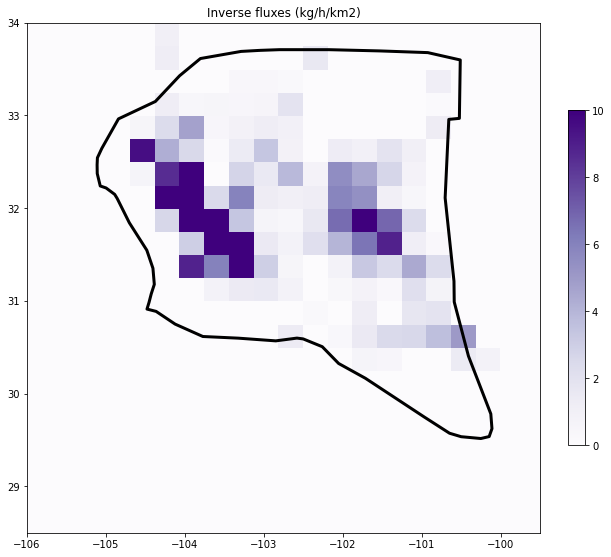

In [67]:
#Plot inverse fluxes

big_grid = pd.DataFrame(np.array([(x, y) for y in cluster_lat for x in cluster_lon]), columns=['lon', 'lat'])
big_grid['ind'] = np.arange(big_grid.shape[0])

small_grid = pd.DataFrame(zip(cllon, cllat), columns=['lon', 'lat'])
small_grid['sind'] = np.arange(small_grid.shape[0])

merge_grid = pd.merge(big_grid, small_grid, how='inner', on=['lon', 'lat'])

big_grid['emis'] = 0
big_grid.loc[merge_grid.ind, 'emis'] = xh_grid2

flux_grid = np.array(big_grid.emis).reshape((len(cluster_lat), len(cluster_lon))) * 3600 * 1000 * 1000

fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ccmap = 'Purples'

c = ax1.pcolormesh(cluster_lon, cluster_lat, flux_grid, cmap=ccmap, vmin=0, vmax=1e-5 * 1000 * 1000)
fig.colorbar(c, ax=ax1, fraction=0.03)
us.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=3)
ax1.set_xlim((-106, -99.5))
ax1.set_ylim((28.5, 34))
ax1.set_title('Inverse fluxes (kg/h/km2)')
plt.show()


Plotting sector: oil


/Users/cusworth/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/cusworth/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


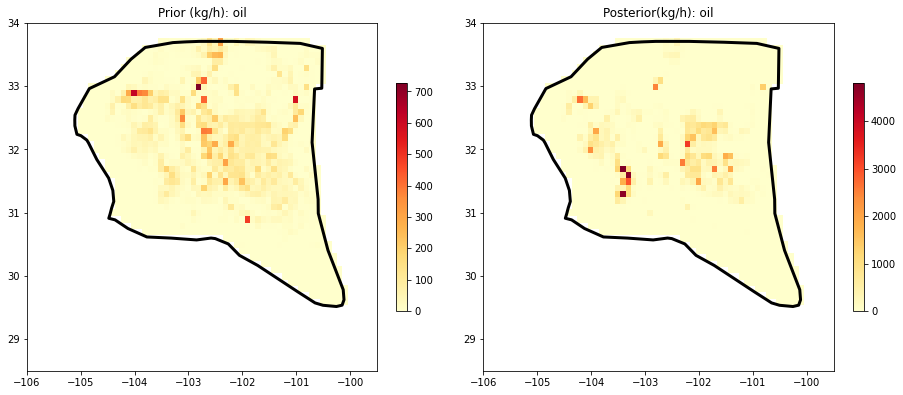

In [75]:
#Pick an emission sector to plot - change variable "idx" - refer to "full_vars" to get indices of sectors
idx = 2

print('Plotting sector:', full_vars[idx])

ind1 = idx*Nlen
ind2 = (idx+1)*Nlen

#Sum emissions
xg = zhat[ind1:ind2]
pg = z_a[ind1:ind2]

#Grid emissions in each sector
ogrid = tgrid.copy()
ogrid['post'] = np.nan
ogrid['prior'] = np.nan
ogrid.loc[tsel, 'post'] = xg
ogrid.loc[tsel, 'prior'] = pg
xgrid = np.array(ogrid.post).reshape((len(lat), len(lon))) 
pgrid = np.array(ogrid.prior).reshape((len(lat), len(lon)))

#Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

c = ax1.pcolormesh(lon, lat, pgrid, cmap='YlOrRd', vmin=0)
fig.colorbar(c, ax=ax1, fraction=0.03)
us.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=3)
ax1.set_xlim((-106, -99.5))
ax1.set_ylim((28.5, 34))
ax1.set_title('Prior (kg/h): '+full_vars[idx])


c = ax2.pcolormesh(lon, lat, xgrid, cmap='YlOrRd', vmin=0)
fig.colorbar(c, ax=ax2, fraction=0.03)
us.plot(ax=ax2, facecolor='none', edgecolor='k', linewidth=3)
ax2.set_xlim((-106, -99.5))
ax2.set_ylim((28.5, 34))
ax2.set_title('Posterior(kg/h): '+ full_vars[idx])

plt.show()